# Notebook 3: Búsqueda Semántica

Este notebook cubre la búsqueda semántica usando ChromaDB:
- Conectar a ChromaDB
- Realizar búsquedas por similitud
- Analizar resultados
- Visualizar similitudes
- Calcular precios sugeridos

**Flujo**: Query → Embedding → Búsqueda → Resultados

## 1. Importar Librerías

In [54]:
import chromadb
from chromadb.utils import embedding_functions
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('default')

## 2. Conectar a ChromaDB

In [55]:
BASE_DIR = Path.cwd()
CHROMA_DIR = BASE_DIR / "chroma_propaher_db"
COLLECTION_NAME = "partidas_propaher"
EMBEDDING_MODEL = "paraphrase-multilingual-MiniLM-L12-v2"

client = chromadb.PersistentClient(path=str(CHROMA_DIR))

embedding_fn = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=EMBEDDING_MODEL
)

collection = client.get_collection(
    name=COLLECTION_NAME,
    embedding_function=embedding_fn
)

print(f"Conectado a ChromaDB")
print(f"Colección: {collection.name}")
print(f"Total documentos: {collection.count()}")

Conectado a ChromaDB
Colección: partidas_propaher
Total documentos: 412


## 3. Función de Búsqueda

In [56]:
def buscar(query, n_resultados=5):
    resultados = collection.query(
        query_texts=[query],
        n_results=n_resultados
    )
    
    partidas = []
    precios = []
    similitudes = []
    
    for meta, dist in zip(
        resultados["metadatas"][0],
        resultados["distances"][0]
    ):
        similitud = 1 - dist
        precio = meta["precio_unitario"]
        precios.append(precio)
        similitudes.append(similitud)
        
        partidas.append({
            "concepto": meta["concepto_base"],
            "precio": precio,
            "unidad": meta["unidad"],
            "similitud": similitud,
            "origen": meta["origen"],
            "capitulo": meta["capitulo"]
        })
    
    precio_medio = sum(precios) / len(precios) if precios else 0
    precios_sorted = sorted(precios)
    n = len(precios_sorted)
    precio_mediana = (precios_sorted[n//2] if n % 2 == 1 
                      else (precios_sorted[n//2-1] + precios_sorted[n//2]) / 2) if precios_sorted else 0
    
    precio_ponderado = (sum(p * s for p, s in zip(precios, similitudes)) / 
                        sum(similitudes)) if similitudes and sum(similitudes) > 0 else 0
    
    stats = {
        "precio_medio": precio_medio,
        "precio_mediana": precio_mediana,
        "precio_ponderado": precio_ponderado,
        "precio_min": min(precios) if precios else 0,
        "precio_max": max(precios) if precios else 0,
        "total_resultados": len(partidas)
    }
    
    return partidas, stats

## 4. Ejemplo de Búsqueda 1

In [57]:
query1 = "tubo corrugado M20"

print(f"Búsqueda: '{query1}'")

partidas, stats = buscar(query1, n_resultados=5)

for i, p in enumerate(partidas):
    print(f"\n{i+1}. [{p['similitud']:.0%}] {p['concepto'][:60]}")
    print(f"   {p['precio']:.2f}€/{p['unidad']} | {p['origen'][:40]}")
    print(f"   {p['capitulo'][:50]}")

print(f"\nESTADÍSTICAS DE PRECIO:")
print(f"  Precio Medio (Promedio): {stats['precio_medio']:.2f}€")
print(f"  Precio Mediana: {stats['precio_mediana']:.2f}€")
print(f"  Precio Ponderado (por similitud): {stats['precio_ponderado']:.2f}€")
print(f"  Precio Mínimo: {stats['precio_min']:.2f}€ | Precio Máximo: {stats['precio_max']:.2f}€")

Búsqueda: 'tubo corrugado M20'

1. [69%] Tub d'acer galvanitzat amb soldadura, fabricat amb acer S195
   141.47€/m | 25  MEMORA Guixeres Badalona (Tanatorio)
   GAS

2. [69%] Tub d'acer galvanitzat amb soldadura, fabricat amb acer S195
   141.47€/m | 25  MEMORA Guixeres Badalona (Tanatorio)
   GAS

3. [67%] Tub d'acer negre prefabricat llis, sense soldadura, fabricat
   85.01€/m | 25  MEMORA Guixeres Badalona (Tanatorio)
   XARXA DE BOQUES D'INCENDI EQUIPADES

4. [66%] Tub d'acer negre prefabricat llis, sense soldadura, fabricat
   51.72€/m | 25  MEMORA Guixeres Badalona (Tanatorio)
   XARXA DE BOQUES D'INCENDI EQUIPADES

5. [64%] Tub d'acer negre prefabricat llis, sense soldadura , fabrica
   44.38€/m | 25  MEMORA Guixeres Badalona (Tanatorio)
   XARXA DE BOQUES D'INCENDI EQUIPADES

ESTADÍSTICAS DE PRECIO:
  Precio Medio (Promedio): 92.81€
  Precio Mediana: 85.01€
  Precio Ponderado (por similitud): 93.90€
  Precio Mínimo: 44.38€ | Precio Máximo: 141.47€


## 5. Ejemplo de Búsqueda 2

In [58]:
query2 = "instalación eléctrica vivienda completa"

print(f"Búsqueda: '{query2}'")

partidas2, stats2 = buscar(query2, n_resultados=5)

for i, p in enumerate(partidas2):
    print(f"\n{i+1}. [{p['similitud']:.0%}] {p['concepto'][:60]}")
    print(f"   {p['precio']:.2f}€/{p['unidad']} | {p['origen'][:40]}")

print(f"\nESTADÍSTICAS DE PRECIO:")
print(f"  Precio Medio (Promedio): {stats2['precio_medio']:.2f}€")
print(f"  Precio Mediana: {stats2['precio_mediana']:.2f}€")
print(f"  Precio Ponderado (por similitud): {stats2['precio_ponderado']:.2f}€")
print(f"  Precio Mínimo: {stats2['precio_min']:.2f}€ | Precio Máximo: {stats2['precio_max']:.2f}€")

Búsqueda: 'instalación eléctrica vivienda completa'

1. [56%] Subministrament i instal·lació d'Inversor per a instal·lació
   5850.00€/ud | 25  MEMORA Guixeres Badalona (Tanatorio)

2. [56%] Realització i tramitació de projecte específic d'una instal·
   1330.00€/ud | 25  MEMORA Guixeres Badalona (Tanatorio)

3. [55%] Subministrament i instal.lació de cable elèctric unipolar
   23.28€/m | 25  MEMORA Guixeres Badalona (Tanatorio)

4. [55%] Subministrament i instal.lació de cable elèctric unipolar
   12.13€/m | 25  MEMORA Guixeres Badalona (Tanatorio)

5. [54%] Subministrament i instal.lació d'electroimant per a retenció
   140.49€/ud | 25  MEMORA Guixeres Badalona (Tanatorio)

ESTADÍSTICAS DE PRECIO:
  Precio Medio (Promedio): 1471.18€
  Precio Mediana: 140.49€
  Precio Ponderado (por similitud): 1493.01€
  Precio Mínimo: 12.13€ | Precio Máximo: 5850.00€


## 6. Ejemplo de Búsqueda 3

In [59]:
query3 = "Caixa de recàrrega de vehicle elèctric, metàl·lica"

print(f"Búsqueda: '{query3}'")

partidas3, stats3 = buscar(query3, n_resultados=5)

for i, p in enumerate(partidas3):
    print(f"\n{i+1}. [{p['similitud']:.0%}] {p['concepto'][:60]}")
    print(f"   {p['precio']:.2f}€/{p['unidad']} | {p['origen'][:40]}")

print(f"\nESTADÍSTICAS DE PRECIO:")
print(f"  Precio Medio (Promedio): {stats3['precio_medio']:.2f}€")
print(f"  Precio Mediana: {stats3['precio_mediana']:.2f}€")
print(f"  Precio Ponderado (por similitud): {stats3['precio_ponderado']:.2f}€")
print(f"  Precio Mínimo: {stats3['precio_min']:.2f}€ | Precio Máximo: {stats3['precio_max']:.2f}€")

Búsqueda: 'Caixa de recàrrega de vehicle elèctric, metàl·lica'

1. [70%] Caixa de recàrrega de vehicle elèctric, metàl·lica, amb grau
   1960.80€/ud | 25  MEMORA Guixeres Badalona (Tanatorio)

2. [61%] Subministrament i instal.lació d'electroimant per a retenció
   140.49€/ud | 25  MEMORA Guixeres Badalona (Tanatorio)

3. [60%] Alimentació elèctrica a aparell trifàsic inclosos conductor 
   248.82€/ud | 25  MEMORA Guixeres Badalona (Tanatorio)

4. [60%] Subministrament i instalació de recuperador entàlpic marca M
   3180.80€/ud | 25  MEMORA Guixeres Badalona (Tanatorio)

5. [60%] Obreportes elèctric d'accionament automàtic, amb palanca de 
   58.32€/ud | 25  MEMORA Guixeres Badalona (Tanatorio)

ESTADÍSTICAS DE PRECIO:
  Precio Medio (Promedio): 1117.85€
  Precio Mediana: 248.82€
  Precio Ponderado (por similitud): 1142.10€
  Precio Mínimo: 58.32€ | Precio Máximo: 3180.80€


## 7. Visualización de Resultados

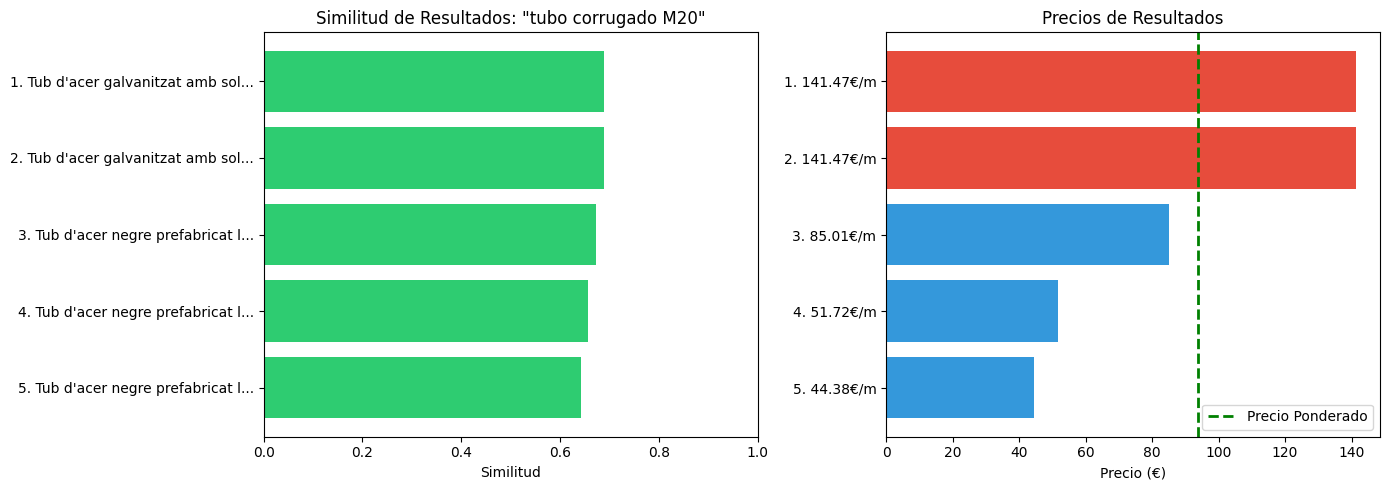

In [60]:
def visualizar_resultados(query, partidas, stats):
    df = pd.DataFrame(partidas)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].barh(range(len(df)), df['similitud'], color='#2ecc71')
    axes[0].set_yticks(range(len(df)))
    axes[0].set_yticklabels([f"{i+1}. {c[:30]}..." for i, c in enumerate(df['concepto'])])
    axes[0].set_xlabel('Similitud')
    axes[0].set_title(f'Similitud de Resultados: "{query}"')
    axes[0].set_xlim(0, 1)
    axes[0].invert_yaxis()
    
    colors = ['#3498db' if p < stats['precio_ponderado'] else '#e74c3c' 
              for p in df['precio']]
    axes[1].barh(range(len(df)), df['precio'], color=colors)
    axes[1].set_yticks(range(len(df)))
    axes[1].set_yticklabels([f"{i+1}. {p:.2f}€/{u}" 
                             for i, (p, u) in enumerate(zip(df['precio'], df['unidad']))])
    axes[1].set_xlabel('Precio (€)')
    axes[1].set_title('Precios de Resultados')
    axes[1].axvline(stats['precio_ponderado'], color='green', 
                    linestyle='--', linewidth=2, label='Precio Ponderado')
    axes[1].legend()
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

visualizar_resultados(query1, partidas, stats)

## 8. Comparación de Múltiples Búsquedas

In [61]:
busquedas = [
    "tubo corrugado",
    "cable RZ1 4x10",
    "cuadro eléctrico",
    "punto de luz",
    "mecanismo conmutador"
]

resultados_comparacion = []

for q in busquedas:
    partidas_q, stats_q = buscar(q, n_resultados=3)
    resultados_comparacion.append({
        "query": q,
        "precio_medio": stats_q['precio_medio'],
        "precio_mediana": stats_q['precio_mediana'],
        "precio_ponderado": stats_q['precio_ponderado'],
        "precio_min": stats_q['precio_min'],
        "precio_max": stats_q['precio_max'],
        "similitud_media": sum(p['similitud'] for p in partidas_q) / len(partidas_q)
    })
    print(f"{q}: Medio={stats_q['precio_medio']:.2f}€, Ponderado={stats_q['precio_ponderado']:.2f}€ (similitud: {resultados_comparacion[-1]['similitud_media']:.0%})")

df_comparacion = pd.DataFrame(resultados_comparacion)

print("\nTabla comparativa:")
display(df_comparacion)

tubo corrugado: Medio=4.58€, Ponderado=4.58€ (similitud: 65%)
cable RZ1 4x10: Medio=80.95€, Ponderado=79.91€ (similitud: 70%)
cuadro eléctrico: Medio=85.43€, Ponderado=87.09€ (similitud: 56%)
punto de luz: Medio=93.62€, Ponderado=93.62€ (similitud: 59%)
mecanismo conmutador: Medio=15.99€, Ponderado=15.88€ (similitud: 48%)

Tabla comparativa:


,query,precio_medio,precio_mediana,precio_ponderado,precio_min,precio_max,similitud_media
0,tubo corrugado,4.575832,4.093833,4.575832,3.104062,6.529600,0.651666
1,cable RZ1 4x10,80.950328,53.993742,79.908116,23.278055,165.579188,0.702382
2,cuadro eléctrico,85.432043,58.316940,87.093888,32.400000,165.579188,0.560353
3,punto de luz,93.625000,71.975000,93.625000,67.450000,141.450000,0.586211
4,mecanismo conmutador,15.986687,14.360000,15.882184,13.128276,20.471786,0.483481


## 9. Análisis de Calidad de Búsqueda

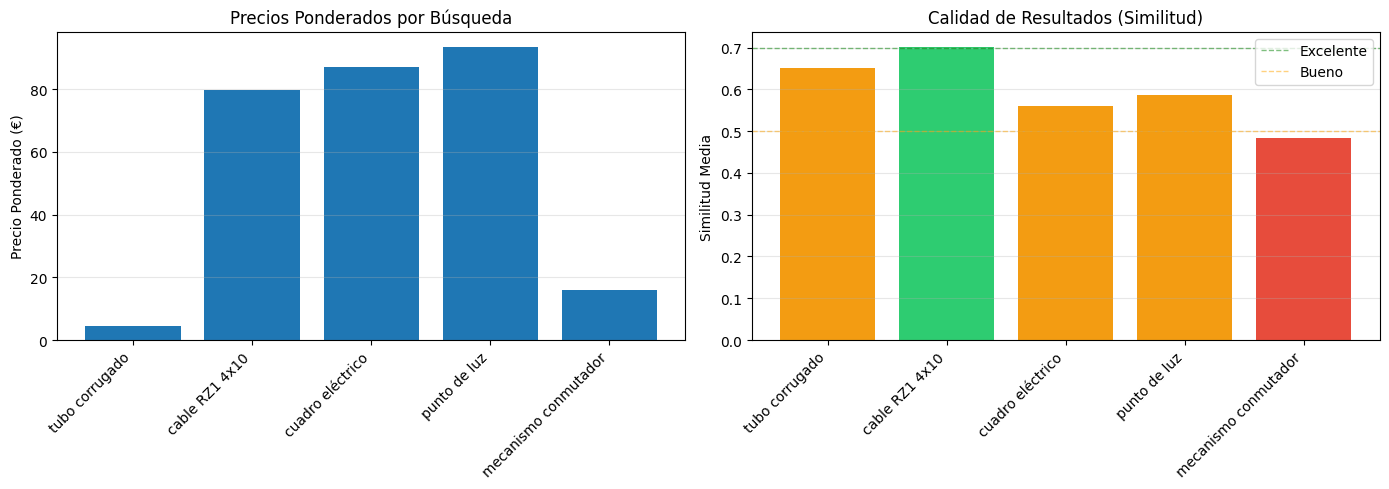

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(len(df_comparacion)), df_comparacion['precio_ponderado'])
axes[0].set_xticks(range(len(df_comparacion)))
axes[0].set_xticklabels(df_comparacion['query'], rotation=45, ha='right')
axes[0].set_ylabel('Precio Ponderado (€)')
axes[0].set_title('Precios Ponderados por Búsqueda')
axes[0].grid(axis='y', alpha=0.3)

colors = ['#2ecc71' if s > 0.7 else '#f39c12' if s > 0.5 else '#e74c3c' 
          for s in df_comparacion['similitud_media']]
axes[1].bar(range(len(df_comparacion)), df_comparacion['similitud_media'], color=colors)
axes[1].set_xticks(range(len(df_comparacion)))
axes[1].set_xticklabels(df_comparacion['query'], rotation=45, ha='right')
axes[1].set_ylabel('Similitud Media')
axes[1].set_title('Calidad de Resultados (Similitud)')
axes[1].axhline(0.7, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Excelente')
axes[1].axhline(0.5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Bueno')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Búsqueda Personalizada

Búsqueda personalizada: 'Caixes aïllants IP55 de derivació amb tapa cargolada i entrades elàstiques/roscades.- Derivació a mecanisme: Cable de coure 07Z1-K, tub de material plàstic lliure d'halògens aïllant flexible/ rígid no propagador de flama.- Línia des de subquadre: cable de coure RZ1-K 0,6/1 kV, safata d'acer galvanitzat, amb conductor de terra de coure nu 16mm2, accessoris i suports.'

1. [87%] Punt de connexió a ventilador (sortida de fils incloent cables i canalització de línia des de quadre de zona). 
Característiques:
- Derivació a receptor: Cable de coure 07Z1-K, tub de material plàstic lliure d'halògens aïllant flexible/rígid no propagador de la flama. Caixes aïllants IP.55 amb tapa cargolada i entrades elàstiques i roscades.
- Línia des de quadre: Cable de coure RZ1-K 0,6/1 kV, safata d'acer galvanitzada, amb conductor de terra de coure nu de 16 mm2, accessoris i suportacions.
Configuració del cable i secció de conductors
   53.99€/ud
   25  MEMORA Guixeres Badalona (Tana

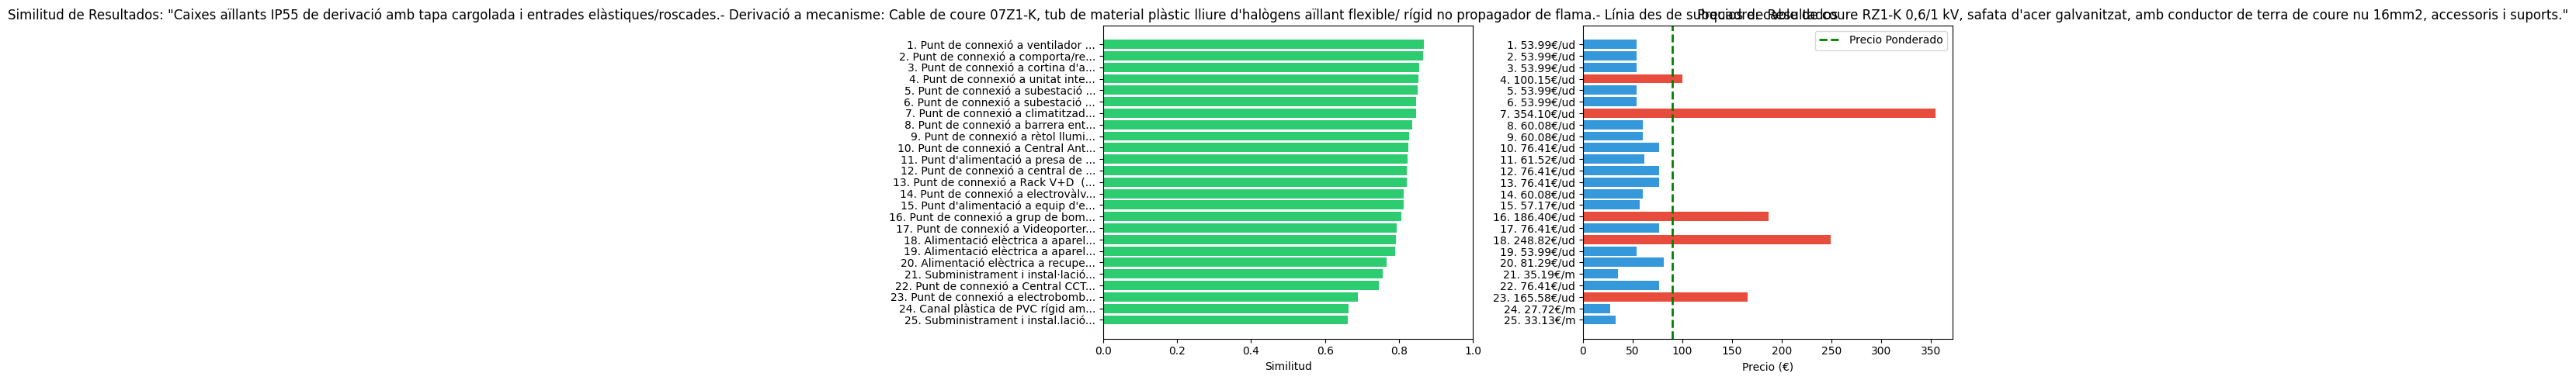

In [65]:
mi_query = "Caixes aïllants IP55 de derivació amb tapa cargolada i entrades elàstiques/roscades.- Derivació a mecanisme: Cable de coure 07Z1-K, tub de material plàstic lliure d'halògens aïllant flexible/ rígid no propagador de flama.- Línia des de subquadre: cable de coure RZ1-K 0,6/1 kV, safata d'acer galvanitzat, amb conductor de terra de coure nu 16mm2, accessoris i suports."
num_resultados = 25

print(f"Búsqueda personalizada: '{mi_query}'")

mis_partidas, mis_stats = buscar(mi_query, n_resultados=num_resultados)

for i, p in enumerate(mis_partidas):
    print(f"\n{i+1}. [{p['similitud']:.0%}] {p['concepto']}")
    print(f"   {p['precio']:.2f}€/{p['unidad']}")
    print(f"   {p['origen']}")
    print(f"   {p['capitulo']}")

print(f"\nESTADÍSTICAS DE PRECIO:")
print(f"  Precio Medio (Promedio): {mis_stats['precio_medio']:.2f}€")
print(f"  Precio Mediana: {mis_stats['precio_mediana']:.2f}€")
print(f"  Precio Ponderado (por similitud): {mis_stats['precio_ponderado']:.2f}€")
print(f"  Precio Mínimo: {mis_stats['precio_min']:.2f}€ | Precio Máximo: {mis_stats['precio_max']:.2f}€")

visualizar_resultados(mi_query, mis_partidas, mis_stats)